In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
!unzip drive/MyDrive/DL/NaturalImagesDataset.zip > out.txt

replace val/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace __MACOSX/val/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [72]:
!ls

data  drive  __MACOSX  out.txt	sample_data  test  train  val


In [42]:
!mkdir data
!mv train data
!mv val data
!mv test data

In [47]:
!ls
!ls data
!ls data/test
!ls data/test/airplane

data  drive  __MACOSX  sample_data
test  train  val
airplane  car  cat  dog  flower  fruit	motorbike  person
airplane_0005.jpg  airplane_0132.jpg  airplane_0293.jpg  airplane_0486.jpg
airplane_0008.jpg  airplane_0135.jpg  airplane_0308.jpg  airplane_0494.jpg
airplane_0013.jpg  airplane_0136.jpg  airplane_0337.jpg  airplane_0527.jpg
airplane_0025.jpg  airplane_0157.jpg  airplane_0349.jpg  airplane_0536.jpg
airplane_0027.jpg  airplane_0159.jpg  airplane_0358.jpg  airplane_0539.jpg
airplane_0031.jpg  airplane_0170.jpg  airplane_0362.jpg  airplane_0542.jpg
airplane_0051.jpg  airplane_0182.jpg  airplane_0375.jpg  airplane_0550.jpg
airplane_0058.jpg  airplane_0188.jpg  airplane_0380.jpg  airplane_0558.jpg
airplane_0064.jpg  airplane_0208.jpg  airplane_0384.jpg  airplane_0560.jpg
airplane_0069.jpg  airplane_0213.jpg  airplane_0406.jpg  airplane_0565.jpg
airplane_0075.jpg  airplane_0237.jpg  airplane_0418.jpg  airplane_0584.jpg
airplane_0079.jpg  airplane_0259.jpg  airplane_0419.jpg  airplane_

In [48]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from PIL import Image
import torchvision.models as models

In [49]:
conv1 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), groups=1) # 1 kernels of the shape 24x12x3x3
conv2 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), groups=2) # 2 kernels of the shape  12x6x3x3
conv3 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), groups=3) # 3 kernels of the shape   8x4x3x3
conv4 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), groups=4) # 4 kernels of the shape   6x3x3x3

In [50]:
print(conv1.weight.shape, conv1.bias.shape)
print(conv2.weight.shape, conv2.bias.shape)
print(conv3.weight.shape, conv3.bias.shape)
print(conv4.weight.shape, conv4.bias.shape)

torch.Size([24, 12, 3, 3]) torch.Size([24])
torch.Size([24, 6, 3, 3]) torch.Size([24])
torch.Size([24, 4, 3, 3]) torch.Size([24])
torch.Size([24, 3, 3, 3]) torch.Size([24])


# AlexNet

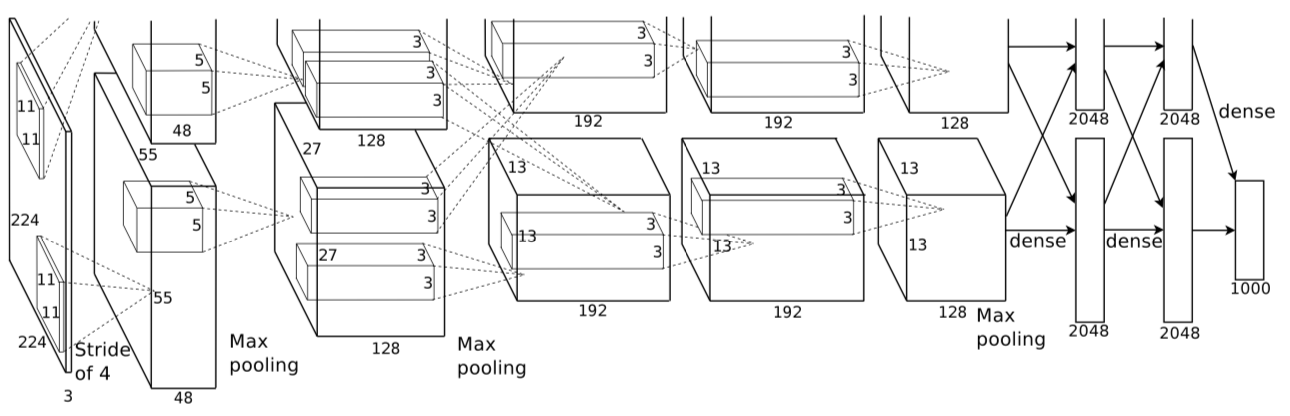

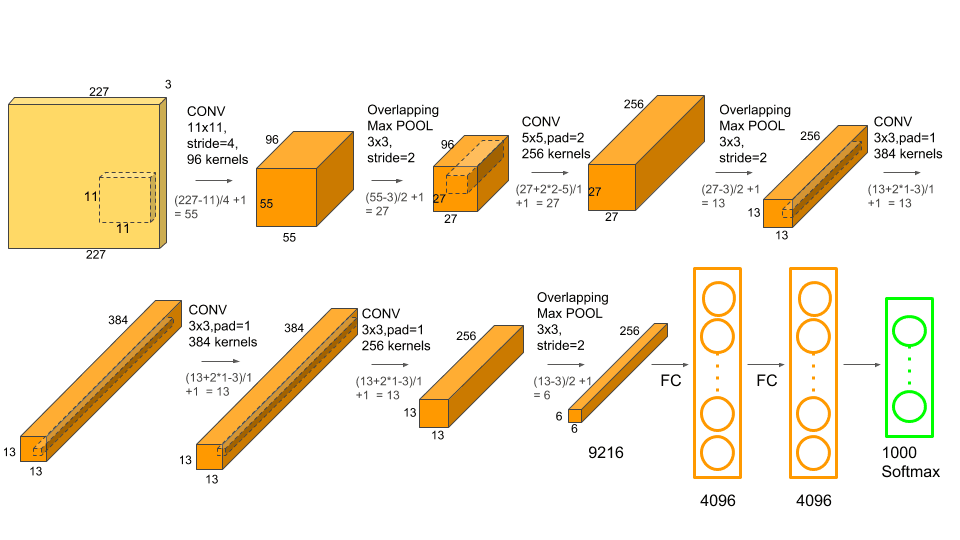

In [51]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=48 * 2,
                kernel_size=(11, 11),
                stride=4,
            ),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(
                in_channels=48 * 2,
                out_channels=128 * 2,
                kernel_size=(5, 5),
                stride=1,
                padding=2,
                groups=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(
                in_channels=128 * 2,
                out_channels=192 * 2,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
                groups=2,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=192 * 2,
                out_channels=192 * 2,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
                groups=2,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=192 * 2,
                out_channels=128 * 2,
                kernel_size=(3, 3),
                stride=1,
                padding=1,
                groups=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            nn.Flatten(),
            
            nn.Linear(6 * 6 * 256, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, input):
        output = self.model(input)
        return output

In [52]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((227, 227)),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomVerticalFlip(),
    # torchvision.transforms.RandomPerspective(distortion_scale=0.2),
    # torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=0, std=1),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((227, 227)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=0, std=1),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((227, 227)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=0, std=1),
])

train_dataset = torchvision.datasets.ImageFolder(root='data/train', transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root='data/val', transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root='data/test', transform=test_transforms)

0


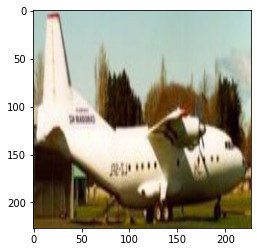

In [53]:
image = train_dataset[3][0].permute(1, 2, 0)
print(train_dataset[3][1])
plt.imshow(image)
plt.show()

In [54]:
def accuracy(outputs, labels):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
  
def predicts(outputs):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return preds
  
criterion = torch.nn.CrossEntropyLoss()

In [55]:
def train(model, batch, optimizer):
    model.train()
    optimizer.zero_grad()
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    l = criterion(outputs, labels)
    l.backward()
    optimizer.step()
    return l


def evaluate(model, batch, optimizer):
    model.eval()
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    a = accuracy(outputs, labels)
    l = criterion(outputs, labels)
    return a, l

In [59]:
model = AlexNet(8)
model.cuda()

AlexNet(
  (model): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=9216, out_features=4096, bias=True)
    (15): ReLU()
    (16): Linear(in_features=4096, out_features=4096, bias=True)
    (17): ReLU()
    (18): Linear(in

In [61]:
LEARNING_RATE = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
epoches = 100

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100)

for epoch in range(epoches):
    print('Epoch:', epoch + 1)
    c = 0
    for batch in train_loader:
        l = train(model, batch, optimizer)
        c += len(batch[0])
        print("[%d/%d] Loss: %.2f" % (c, len(train_dataset), l.item()))
      
    for batch in train_loader:
        a, l = evaluate(model, batch, optimizer)
        print("Train Loss: %.2f, Train Accuracy: %.2f" % (l.item(), a.item()))
        break

    acc = 0
    loo = 0
    d = 0
    for batch in val_loader:
        a, l = evaluate(model, batch, optimizer)
        acc += a.item()
        loo += l.item()
        d += 1
    print("Val Loss: %.2f, Val Accuracy: %.2f" % (loo / d, acc / d))
    
    torch.save(model.state_dict(), 'drive/MyDrive/DL/alexnet.pt')

Epoch: 1
[100/5519] Loss: 0.48
[200/5519] Loss: 0.78
[300/5519] Loss: 0.63
[400/5519] Loss: 0.75
[500/5519] Loss: 0.79
[600/5519] Loss: 0.48
[700/5519] Loss: 0.48
[800/5519] Loss: 0.62
[900/5519] Loss: 0.60
[1000/5519] Loss: 0.47
[1100/5519] Loss: 0.40
[1200/5519] Loss: 0.60
[1300/5519] Loss: 0.38
[1400/5519] Loss: 0.36
[1500/5519] Loss: 0.55
[1600/5519] Loss: 0.55
[1700/5519] Loss: 0.55
[1800/5519] Loss: 0.41
[1900/5519] Loss: 0.49
[2000/5519] Loss: 0.43
[2100/5519] Loss: 0.59
[2200/5519] Loss: 0.41
[2300/5519] Loss: 0.51
[2400/5519] Loss: 0.58
[2500/5519] Loss: 0.58
[2600/5519] Loss: 0.35
[2700/5519] Loss: 0.51
[2800/5519] Loss: 0.48
[2900/5519] Loss: 0.40
[3000/5519] Loss: 0.47
[3100/5519] Loss: 0.50
[3200/5519] Loss: 0.34
[3300/5519] Loss: 0.44
[3400/5519] Loss: 0.40
[3500/5519] Loss: 0.45
[3600/5519] Loss: 0.42
[3700/5519] Loss: 0.33
[3800/5519] Loss: 0.55
[3900/5519] Loss: 0.50
[4000/5519] Loss: 0.38
[4100/5519] Loss: 0.66
[4200/5519] Loss: 0.46
[4300/5519] Loss: 0.40
[4400/5519]

KeyboardInterrupt: ignored

In [62]:
def info(item):
    input = item[0]
    input = input.cuda()
    output = model(input.unsqueeze(0))
    print("Output: %s" % output.argmax(dim=1).item(), "Expected: %s" % item[1])

In [63]:
for x in test_dataset:
    info(x)

Output: 0 Expected: 0
Output: 4 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 2 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 3 Expected: 0
Output: 3 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 Expected: 0
Output: 0 